In [4]:
import numpy as np
from typing import Union, List, Callable, Any, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import math

pd.set_option("display.precision", 24)


# This function is used to form polynomial from roots which will be used in
# Newton-Cotes formula and Gaussian Quadrature.
# The parameter alpha and beta will only be used when called in Double and Triple Gaussian Integral 
def integPolynomial(index:int, roots:np.ndarray, coef:np.ndarray, alpha:float=None, beta:float=None) -> float:
    idxs = np.arange(len(roots)) != index
    poly = np.polynomial.Polynomial.fromroots(roots[idxs])
    an_poly = poly.integ()
    coef[index] = an_poly(1) - an_poly(-1)
    coef[index] /= np.prod(roots[index] - roots[idxs])
    if (alpha is not None) and (beta is not None):
        return alpha * roots[index] + beta

def NewtonDiff(func: Union[Callable[[Union[float, int]], float],
                           np.ndarray[Union[float, int], Any],
                           List[Union[int, float]]],
            x_: Union[np.ndarray[Union[float, int], Any], List[Union[int, float]]],
            return_Q: bool=False,
            ) -> Union[Callable[[Union[float, int]], float],
                       Tuple[Callable[[Union[float, int]], float], np.ndarray[Union[float, int], Any]]]:
    
    f_call = callable(func)
    n = len(x_)
    Q = np.zeros((n, n))
    
    for idx in range(n):
        Q[idx][0] = func(x_[idx]) if f_call else func[idx]

    for idx in range(1, n):
        for jdx in range(1, idx + 1):
            Q[idx][jdx] = (Q[idx][jdx - 1] -  Q[idx - 1][jdx - 1]) / (x_[idx] - x_[idx - jdx])

    def interpolation(x: float) -> float:
        appro = Q[0][0]
        for idx in range(1, n):
            prod = 1
            for jdx in range(idx):
                prod *= (x - x_[jdx])
            appro += Q[idx][idx] * prod 
        return appro

    return interpolation if not return_Q else (interpolation, Q)

# Chapter 4.1 - 4.2 Numerical Differentiation

## Chapter 4.1 Numerical Differentiation

To obtain general derivative approximation formulas, suppose $x_0, x_1,\cdots x_n$ are $(n + 1)$ distinct numbers in some interval $I$ and that $f\in C^{n+1}(I)$, from [Chapter 3.1/Error Analysis](Chapter%203.ipynb#Error%20Analysis)
$$
f(x)=\sum_{k=0}^{n}f(x_k)L_k(x)+\frac{(x-x_0)(x-x_1)\cdots(x-x_n)}{(n+1)!}f^{(n+1)}(\xi(x))
$$
for some $\xi(x)$ in $I$, where $L_k(x)$ denotes the $k$ th _Lagrange coefficient polynomial_ for $f$ at $x_0, x_1,\cdots x_n$. Differentiating this expression gives

$$
\begin{split}
f'(x)=\sum_{k=0}^nf(x_k)L'(x_k)+\frac{d}{dx}\biggl[\frac{(x-x_0)(x-x_1)\cdots(x-x_n)}{(n+1)!}f^{(n+1)}(\xi(x))\biggr] \\ +\frac{(x-x_0)(x-x_1)\cdots(x-x_n)}{(n+1)!}f^{(n+1)}(\xi(x))\frac{d}{dx}f^{(n+1)}(\xi(x))
\end{split}
$$

which is called $(n+1)$-point formula

In [ ]:
def diff(func:Union[Callable[[Union[float, int]], float],
                        np.ndarray[Union[float, int], Any],
                        List[Union[int, float]]],
         x:Union[int, float],
         h:float,
         num_points:int,
         mode:str="end") -> float:
    '''
    The values of function at x are assumed to be given in a forward order if the 
    parameter func is an numpy array or list
    Example:
    x = [2.1, 2.2, 2.3, 2.4, 2.5, 2.6]
    f = [
            -1.709847, -1.373823, -1.119214, 
            -0.9160143, -0.7470223, -0.6015966
        ]
    Then f(2.1) = -1.709847 etc
    Values of f and x are corresponding.
    '''
    # Maybe the points are not necessary to be equally spaced ?
    if mode == "end":
        x_ = x + np.arange(num_points) * h
        if h < 0:
            x_ = x_[::-1]
    elif mode == "mid":
        x_ = x + np.arange(-(num_points - 1) / 2, ((num_points - 1) / 2) + 1) * h
    else:
        raise ValueError("Mode must be either end or mid")
    y_ = func(x_) if callable(func) else func
    coef = np.zeros(num_points, dtype=float)
    for idx in range(num_points):
        idxs = np.arange(num_points) != idx
        poly = np.polynomial.Polynomial.fromroots(x_[idxs])
        de_poly = np.polynomial.Polynomial.deriv(poly)
        coef[idx] = de_poly(x)
        coef[idx] /= np.prod(x_[idx] - x_[idxs])
    return np.sum(y_ * coef)

In [6]:
# Example 2
f = lambda x: x * np.exp(x)
print(diff(f, 2.0, 0.1, 3))
print(diff(f, 2.0, -0.1, 3))
print(diff(f, 2.0, 0.1, 3, "mid"))
print(diff(f, 2.0, 0.1, 5, "mid"))

22.032304866146504
22.05452134102333
22.22878688030754
22.166995621551198


In [7]:
# Exercise 9

print("Question a")
x = [2.1, 2.2, 2.3, 2.4, 2.5, 2.6]
f = [
    -1.709847, -1.373823, -1.119214, 
    -0.9160143, -0.7470223, -0.6015966
    ]

print(diff(f[:5], 2.1, 0.1, 5, "end"))
print(diff(f[1:], 2.2, 0.1, 5, "end"))
print(diff(f[:5], 2.3, 0.1, 5, "mid"))
print(diff(f[1:], 2.4, 0.1, 5, "mid"))
print(diff(f[:5], 2.5, -0.1, 5, "end"))
print(diff(f[1:], 2.6, -0.1, 5, "end"))

print("Question b")
x = [-3.0, -2.8, -2.6, -2.4, -2.2, -2.0]
f = [
    9.367879, 8.233241, 7.180350,
    6.209329, 5.320305, 4.513417
]

print(diff(f[:5], -3.0, 0.2, 5, "end"))
print(diff(f[1:], -2.8, 0.2, 5, "end"))
print(diff(f[:5], -2.6, 0.2, 5, "mid"))
print(diff(f[1:], -2.4, 0.2, 5, "mid"))
print(diff(f[:5], -2.2, -0.2, 5, "end"))
print(diff(f[1:], -2.0, -0.2, 5, "end"))

Question a
3.8993442498672533
2.8768756667474094
2.249704083283343
1.837755999964177
1.5442099165322176
1.3554963334747345
Question b
-5.8773574999506355
-5.46893333336326
-5.059884166669667
-4.65022333334556
-4.239910833341746
-3.8288533333480643


## Chapter 4.2 Richardson's Extrapolation
Richardson’s extrapolation is used to generate high-accuracy results while using low-order formulas. Extrapolation can be applied whenever it is known that an approximation technique
has an error term with a predictable form, one that depends on a parameter, usually the step size $h$. Suppose that for each number $h\neq0$ we have a function $N_1(h)$ approximates an unknown constant $M$, and that the truncation error involved has the form
$$
M-N_i(h)=K_1h+K_2h^2+K_3h^3+\cdots
$$
for some unknown constants $K_1, K_2, K_3,\cdots$. The truncation error in this case is $O(h)$, so unless there was a large variation in magnitude among
the constants $K_1, K_2, K_3,\cdots$,
$$
    M-N_1(0.1)\approx0.1K_1\,\,\,\,\,M-N_1(0.01)\approx0.01K_1
$$
and, in general, $M-N_1(h)\approx K_1h$. The object of extrapolation is to find an easy way to combine these rather inaccurate $O(h)$ approximations in an appropriate way to produce formulas with a higher-order truncation error. Extrapolation can be applied whenever the truncation error for a formula has the form
$$
\sum{j=1}^{m-1}K_jh^{\alpha_j}+O(h^{\alpha_m})
$$
for a collection of constants $K_j$ and when $\alpha_1<\alpha_2<\cdots<\alpha_m$. Many formulas used
for extrapolation have truncation errors that contain only even powers of $h$, and a closed form formula is given as following, for each $j=2, 3, \cdots, $the $O(h^{2j})$ approximation is
$$
N_j(h)=N_{j-1}\biggl(\frac{h}{2}\biggr)+\frac{N_{j-1}(h/2)-N_{j-1}(h)}{4^{j-1}-1}
$$

In [8]:
def extrapolation(x:Union[np.ndarray[Union[float, int], Any],
                  List[Union[int, float]]],
                  order:int) -> float:
    if order % 2:
        raise ValueError("Order of truncation error must be even")
    N = order // 2
    R = np.zeros((N, N))
    R[:, 0] = x

    for idx in range(1, N):
        for jdx in range(idx, N):
            R[jdx, idx] = R[jdx, idx - 1] + (R[jdx, idx - 1] - R[jdx - 1, idx - 1]) / (4 ** idx - 1)
    return R

In [9]:
f = lambda x: x * np.exp(x)
d = [diff(f, 2.0, h, 3, "mid") for h in [0.2, 0.1, 0.05, 0.025]]
print(d)
print(extrapolation(d, 8))

[np.float64(22.41416065702938), np.float64(22.22878688030754), np.float64(22.182564857798184), np.float64(22.17101693187874)]
[[22.41416066  0.          0.          0.        ]
 [22.22878688 22.16699562  0.          0.        ]
 [22.18256486 22.16715752 22.16716831  0.        ]
 [22.17101693 22.16716762 22.1671683  22.1671683 ]]


In [10]:
# Exercise 5
x = [1.570796, 1.896119, 1.974232, 1.993570]
extrapolation(x, 8)

array([[1.570796  , 0.        , 0.        , 0.        ],
       [1.896119  , 2.00456   , 0.        , 0.        ],
       [1.974232  , 2.00026967, 1.99998364, 0.        ],
       [1.99357   , 2.000016  , 1.99999909, 1.99999933]])

# Chapter 4.3-4.9 Numerical Integration

## Chapter 4.3 Elements of Numerical Integration

### Trapezoidal Rule
$$ \int_{x_0}^{x_1}f(x)\,dx=\frac{h}{2}[f(x_0)+f(x_1)]-\frac{h^3}{12}f''(\xi) $$
where $x_0=a, x_1=b,h=b-a,\xi\in(a, b)$
### Midpoint Rule
$$\int_{x_{-1}}^{x_{1}}f(x)\,dx=2hf(x_0)+\frac{h^3}{3}f''(\xi)$$
where $x_{-1}=a, x_{1}=b,x_0=a+h,h=\frac{(b-a)}{n+2},\xi\in(a, b)$
### Simpson Rule
$$\int_{x_0}^{x_2}f(x)\,dx=\frac{h}{3}[f(x_0)+4f(x_1)+f(x_2)]-\frac{h^5}{90}f^{(4)}(\xi)$$
where $x_0=a,x_2=b,x_1=a+h,h=\frac{(b-a)}{2}$

In [11]:
def Trapezoidal(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
            a:Union[float, int],
            b:Union[float, int]) -> float:
    return (b - a) * (func(a) + func(b)) / 2
def Midpoint(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
            a:Union[float, int],
            b:Union[float, int]) -> float:
    return 2 * (b - a) * func(a + (a + b) / 2) / 2
def Simpson(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
            a:Union[float, int],
            b:Union[float, int]) -> float:
    return (b - a) * (func(a) + 4 * func(a + (b - a) / 2) + func(b)) / 6

In [12]:
f = lambda x: np.sin(x)
print(Trapezoidal(f, 0, np.pi / 4))
print(Midpoint(f, 0, np.pi / 4))
print(Simpson(f, 0, np.pi / 4))

0.2776801836348979
0.30055886494217315
0.29293263783974804


### Closed Newton-Cotes Formula
The $(n+1)$-_point closed Newton-Cotes formula_ uses nodes $x_i=x_0+ih$, for $i=0,1,\cdots,n$ where $x_0=a,x_n=b,h=\frac{(b-a)}{n}$ It is called closed because the endpoints of the closed interval $[a, b]$ are included as nodes.

Suppose that $\sum_{i=0}^{n}a_if(x_i)$ denotes the $(n+1)$-points closed Newton-Cotes formula with $x_0=a,x_n=b,h=\frac{(b-a)}{n}$. There exists $\xi\in(a, b)$ for which
$$\int_a^bf(x)\,dx=\sum_{i=0}^na_if(x_i)+\frac{h^{n+3}f^{(n+2)}(\xi)}{(n+2)!}\int_0^nt^2(t-1)\cdots(t-n)\,dt$$
if $n$ is even and $f\in C^{n+2}[a, b]$,and
$$\int_a^bf(x)\,dx=\sum_{i=0}^na_if(x_i)+\frac{h^{n+2}f^{(n+1)}(\xi)}{(n+1)!}\int_0^nt(t-1)\cdots(t-n)\,dt$$
if $n$ is odd and $f\in C^{n+1}[a, b]$.

where 
$$a_i=\int_{x_0}^{x_n}L_i(x)\,dx=\int_{x_0}^{x_n}\prod_{\substack{j=0 \\ j\neq i}}^n\frac{(x-x_j)}{(x_i-x_j)}\,dx$$

In [ ]:
def closedNewtonCotesCoef(num_intervals:int) -> np.ndarray:
    '''
    Coefficient of each f in Closed Newton-Cotes formula
    '''
    h = 2 / num_intervals
    num_intervals += 1
    roots = np.linspace(-1, 1, num_intervals)
    coef = np.zeros(num_intervals, dtype=float)
    for idx in range(num_intervals):
        integPolynomial(idx, roots, coef)
    return coef / h

def closedNewtonCotes(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
            a:Union[float, int],
            b:Union[float, int],
            num_intervals:int,
            visualize:bool=False,
            ) -> float:
    '''
    Closed Newton-Cotes Formulae
    '''
    coef = closedNewtonCotesCoef(num_intervals)
    h = (b - a) / num_intervals
    num_intervals += 1
    x = np.linspace(a, b, num_intervals)
    y = func(x)

    if visualize:
        plt.figure(figsize=(16, 12))
        x_ = np.linspace(a, b, 10000)
        plt.fill_between(x_, func(x_), color='chartreuse')
        plt.plot(x_, func(x_), 'r')
        plt.scatter(x, y, s=30)
        plt.fill_between(x, y, edgecolor="black")
        plt.show()
    return np.sum(coef * y) * h

In [14]:
f = lambda x: x * np.sin(x ** 2)

print(closedNewtonCotes(f, 0, np.pi / 4, 1))
print(Trapezoidal(f, 0, np.pi / 4))
print(closedNewtonCotes(f, 0, np.pi / 4, 2))
print(Simpson(f, 0, np.pi / 4))
print(closedNewtonCotes(f, 0, np.pi / 4, 3))    # Simpson's 3/8 Rule
print(closedNewtonCotes(f, 0, np.pi / 4, 4))    # Boole's Rule

0.17841431591583054
0.17841431591583054
0.09105459636913611
0.09105459636913614
0.09163484686235018
0.09212061212709344


### Open Newton-Cotes Formula
The $(n+1)$-_point open Newton-Cotes formula_ uses nodes $x_i=x_0+ih$, for $i=0,1,\cdots,n$ where $x_0=a+h,x_n=b-h,x_{-1}=a, x_{n+1}=b,h=\frac{(b-a)}{(n+2)}$ It is called closed because the endpoints of the closed interval $[a, b]$ are included as nodes.

Suppose that $\sum_{i=0}^{n}a_if(x_i)$ denotes the $(n+1)$-points closed Newton-Cotes formula with $x_{-1}=a,x_{n+1}=b,h=\frac{(b-a)}{n}$. There exists $\xi\in(a, b)$ for which
$$\int_a^bf(x)\,dx=\sum_{i=0}^na_if(x_i)+\frac{h^{n+3}f^{(n+2)}(\xi)}{(n+2)!}\int_{-1}^{n+1}t^2(t-1)\cdots(t-n)\,dt$$
if $n$ is even and $f\in C^{n+2}[a, b]$,and
$$\int_a^bf(x)\,dx=\sum_{i=0}^na_if(x_i)+\frac{h^{n+2}f^{(n+1)}(\xi)}{(n+1)!}\int_{-1}^{n+1}t(t-1)\cdots(t-n)\,dt$$
if $n$ is odd and $f\in C^{n+1}[a, b]$.

where 
$$a_i=\int_{x_0}^{x_n}L_i(x)\,dx=\int_{x_0}^{x_n}\prod_{\substack{j=0 \\ j\neq i}}^n\frac{(x-x_j)}{(x_i-x_j)}\,dx$$

In [ ]:
def openNewtonCotesCoef(num_intervals:int) -> np.ndarray:
    if num_intervals == 0:
        return np.array([2])
    h = 2 / (num_intervals + 2)
    num_intervals += 1
    roots = np.linspace(-1 + h, 1 - h, num_intervals)
    coef = np.zeros(num_intervals, dtype=float)
    for idx in range(num_intervals):
        integPolynomial(idx, roots, coef)
    return coef / h

def openNewtonCotes(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
            a:Union[float, int],
            b:Union[float, int],
            num_intervals:int, 
            visualize:bool=False) -> float:
    coef = openNewtonCotesCoef(num_intervals)
    h = (b - a) / (num_intervals + 2)
    num_intervals += 1
    x = np.linspace(a + h, b - h, num_intervals)
    y = func(x)
    if visualize:
        plt.figure(figsize=(16, 12))
        x_ = np.linspace(a, b, 1000)
        plt.fill_between(x_, func(x_), color='chartreuse')
        plt.plot(x_, func(x_), 'r')
        plt.scatter(x, y, s=30)
        plt.fill_between(x, y, edgecolor="black")
        plt.show()
    return np.sum(coef * y) * h

In [16]:
def NewtonCotesErr(num_points:int,
                a:Union[float, int]=None,
                b:Union[float, int]=None,
                type:str="closed") -> np.ndarray:
    '''
    Coefficient of error term in Closed Newton-Cotes formula
    '''
    if type not in ["closed", "open"]:
        raise ValueError("type must be either closed or open")
    if (b is None) or (a is None):
        h = 1
    else:
        h = (b - a) / num_points
    lb = 0 if type == "closed" else -1
    ub = num_points if type == "closed" else num_points + 1
    roots = np.arange(num_points + 1)
    poly = np.polynomial.Polynomial.fromroots(roots)
    h_power = (num_points + 2)
    err = 1 / math.factorial(num_points + 1)
    if num_points % 2 == 0:
        h_power += 1
        err /= (num_points + 2)
        poly *= np.polynomial.Polynomial(np.array([0, 1]))
    anti_poly = poly.integ()
    t = anti_poly(ub) - anti_poly(lb)
    return err * t * h ** h_power


for idx in range(1, 6):
    print(NewtonCotesErr(idx))
for idx in range(6):
    print(NewtonCotesErr(idx, type="open"))

-0.08333333333333334
-0.011111111111111108
-0.03749999999999987
-0.008465608465609068
-0.022734788359790592
0.3333333333333333
0.7499999999999999
0.31111111111111134
0.6597222222222223
0.2928571428571392
0.6084490740740672


In [17]:
f = lambda x: np.sin(x)

# When n = 0, it is Midpoint Rule but we cannot define the coefficient of it since we do not
# have definition of Lagrange Polynomial interpolated at one point only.
print(openNewtonCotes(f, 0, np.pi / 4, 0))
print(Midpoint(f, 0, np.pi / 4))
print(openNewtonCotes(f, 0, np.pi / 4, 1))
print(openNewtonCotes(f, 0, np.pi / 4, 2))  # Milne's Rule
print(openNewtonCotes(f, 0, np.pi / 4, 3))

0.30055886494217315
0.30055886494217315
0.2979875421872626
0.29285865919259013
0.29286922813608424


## Chapter 4.4 Composite Numerical Integration

### Composite Trapezoidal Rule
Let $f\in C^2[a, b], h=\frac{(b - a)}{n},$ and $x_j=a+jh,$ for each $j=0,1,\cdots,n$. There exists a $\mu\in(a, b)$ for which the __Composite Trapezoidal Rule__ for $n$ subintervals can be written with its error term as
$$
\int_a^bf(x)\,dx=\frac{h}{2}\biggl[
    f(a)+2\sum_{j=1}^{n-1}f(x_j)+f(b)
\biggr]-\frac{b-a}{12}h^2f''(\mu)
$$


In [18]:
def CompositeTrapezoidal(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           h:Union[float, int]=None,
           N:int=None, 
           visualize:bool=False) -> float:
    if (h is None) and (N is None):
        raise ValueError("h and N cannot be None at the same time")
    elif h is None:
        h = (b - a) / N
    elif N is None:
        N = int((b - a) / h)
    x = np.linspace(a, b, N + 1)
    approx = h * (func(a) + func(b)) / 2
    for idx in range(1, N):
        approx += h * func(x[idx])
    if visualize:
        plt.figure(figsize=(16, 12))
        x_ = np.linspace(a, b, 1000)
        plt.fill_between(x_, func(x_), color='chartreuse')
        plt.plot(x_, func(x_), 'r')
        for idx in range(N):
            xs = [x[idx], x[idx], x[idx + 1], x[idx + 1]]
            ys = [0, func(x[idx]), func(x[idx + 1]), 0]
            plt.fill(xs, ys, 'lightskyblue', edgecolor="black")
        plt.show()
    return approx

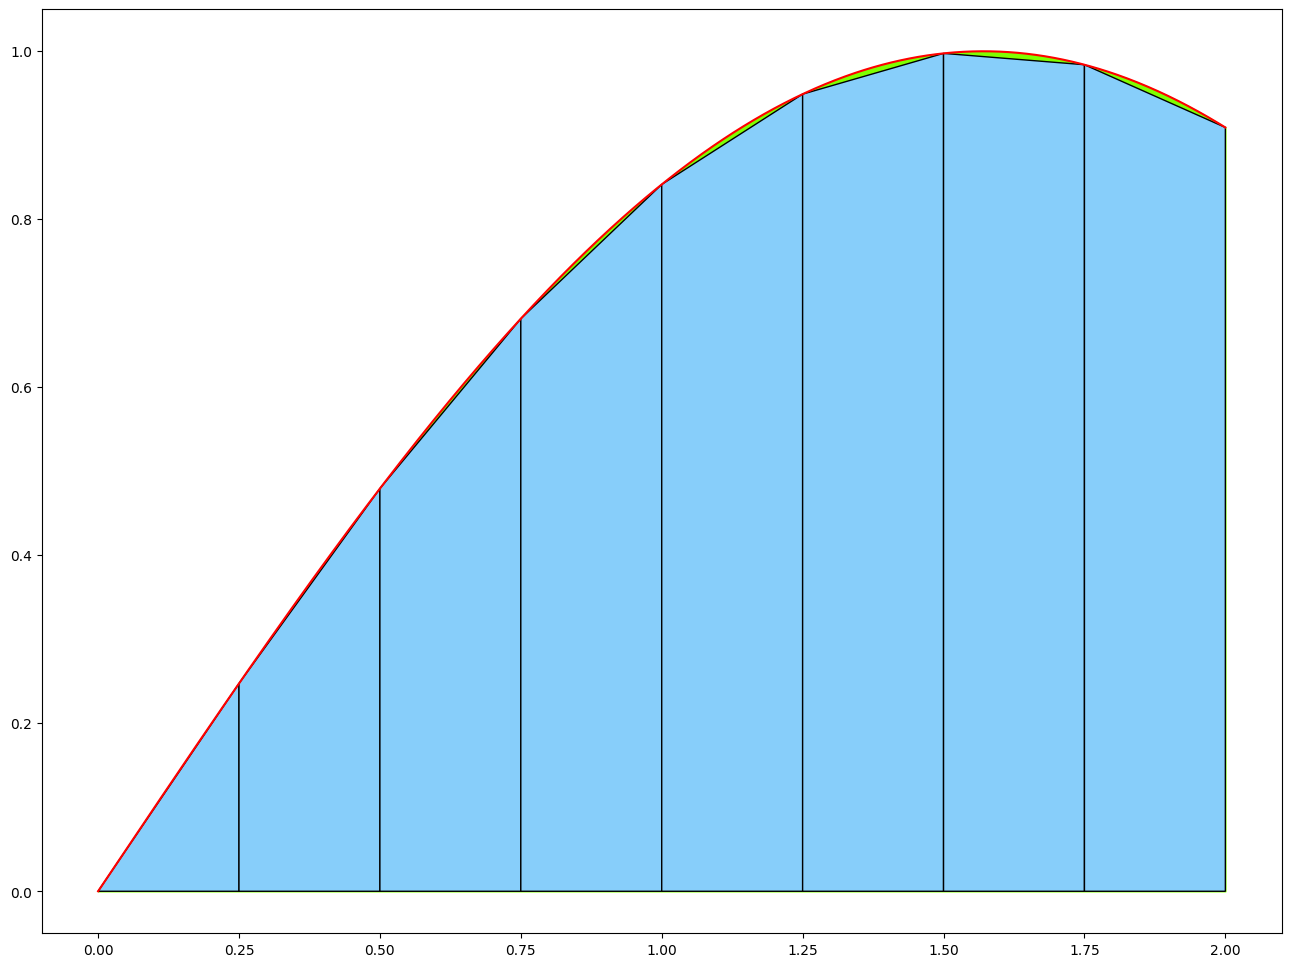

1.4087633772340937


In [19]:
print(CompositeTrapezoidal(f, 0, 2, h=0.25, visualize=True))

### Composite Midpoint Rule
The following codes implement two version of __Midpoint Rule__

i)(Closed, invovle the endpoints) Let $f\in C^2[a, b],h=\frac{(b-a)}{n}$, and $x_j=a+jh$ for each $j=0,1\cdots,n$. There exists a $\mu\in(a, b)$ for which the __Composite Midpoint Rule__ for $n$ subintervals can be written with its error term as 
$$
\int_{a}^bf(x)\,dx=h\sum_{j=1}^{n}f\biggl(\frac{x_{j-1}+x_j}{2}\biggr)+\frac{b-a}{24}h^2f''(\mu)

$$

ii)(Open, does not invovle the endpoints) Let $f\in C^2[a, b],\,\,n$ be even, $h=\frac{(b-a)}{n+2}$, and $x_j=a+(j+1)h$ for each $j=-1,0,\cdots,n+1$. There exists a $\mu\in(a, b)$ for which the __Composite Midpoint Rule__ for $n+2$ subintervals can be written with its error term as 
$$
\int_{a}^bf(x)\,dx=2h\sum_{j=0}^{n/2}f(x_{2j})+\frac{b-a}{6}h^2f''(\mu)

$$


In [ ]:
# Version 1 which compactible with any n
def CompositeMidpoint(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           h:Union[float, int]=None,
           N:int=None, 
           visualize:bool=False) -> float:
    if (h is None) and (N is None):
        raise ValueError("h and N cannot be None at the same time")
    elif h is None:
        h = (b - a) / N
    elif N is None:
        N = int((b - a) / h)
    step = h / 2
    x = np.linspace(a, b, N + 1)
    midpoints = x + step
    approx = 0

    for m in midpoints[:-1]:
        approx += func(m) * h

    if visualize:
        plt.figure(figsize=(16, 12))
        x_ = np.linspace(a, b, 1000)
        plt.fill_between(x_, func(x_), color="chartreuse")
        plt.plot(x_, func(x_), 'r')
        for m in midpoints[:-1]:
            plt.bar(m, func(m), h, color='lightskyblue',  edgecolor="black")
            plt.plot([m, m], [0, func(m)], linestyle="--", color="red")
        plt.xticks(midpoints)
        plt.show()
    return approx

In [205]:
# Version 2 which can only be used when n is even
def CompositeMidpoint_(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           h:Union[float, int]=None,
           N:int=None, 
           visualize:bool=False) -> float:
    if (h is None) and (N is None):
        raise ValueError("h and N cannot be None at the same time")
    elif h is None:
        h = (b - a) / (N + 2)
        x = np.linspace(a, b, N + 3)
    elif N is None:
        N = int((b - a - 2 * h) / h)
        x = np.linspace(a, b, 2 * N + 1)
    midpoints = x
    approx = 0
    for m in midpoints[1:-1:2]:
        approx += func(m) * 2 * h

    if visualize:
        plt.figure(figsize=(16, 12))
        x_ = np.linspace(a, b, 1000)
        plt.fill_between(x_, func(x_), color="chartreuse")
        plt.plot(x_, func(x_), 'r')
        for m in midpoints[1:-1:2]:
            plt.bar(m, func(m), 2 * h, color='lightskyblue',  edgecolor="black")
            plt.plot([m, m], [0, func(m)], linestyle="--", color="red")
        plt.xticks(midpoints)
        plt.show()
    return approx

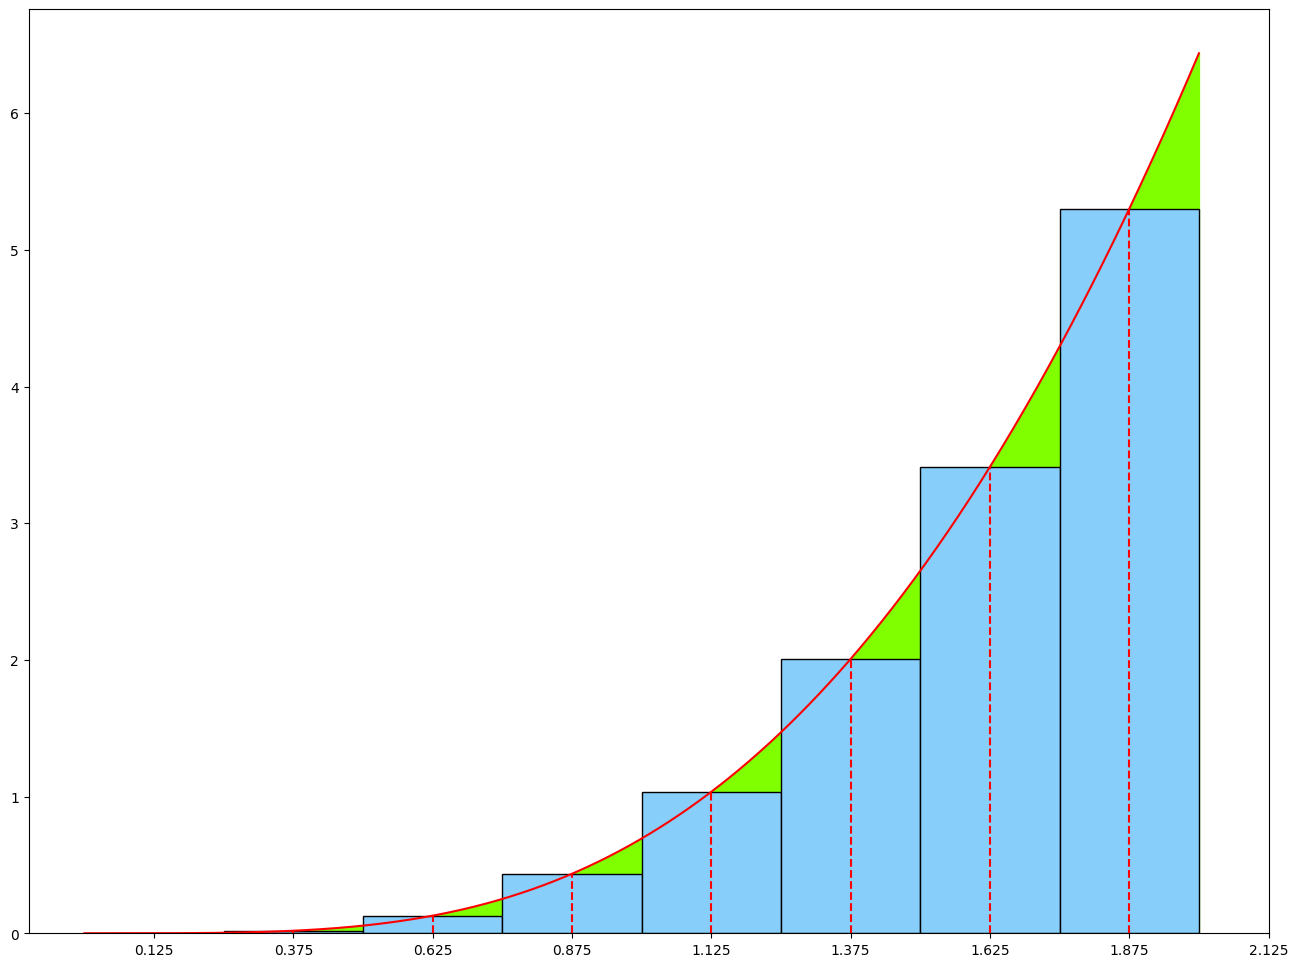

Version 1 :  3.084202849079324


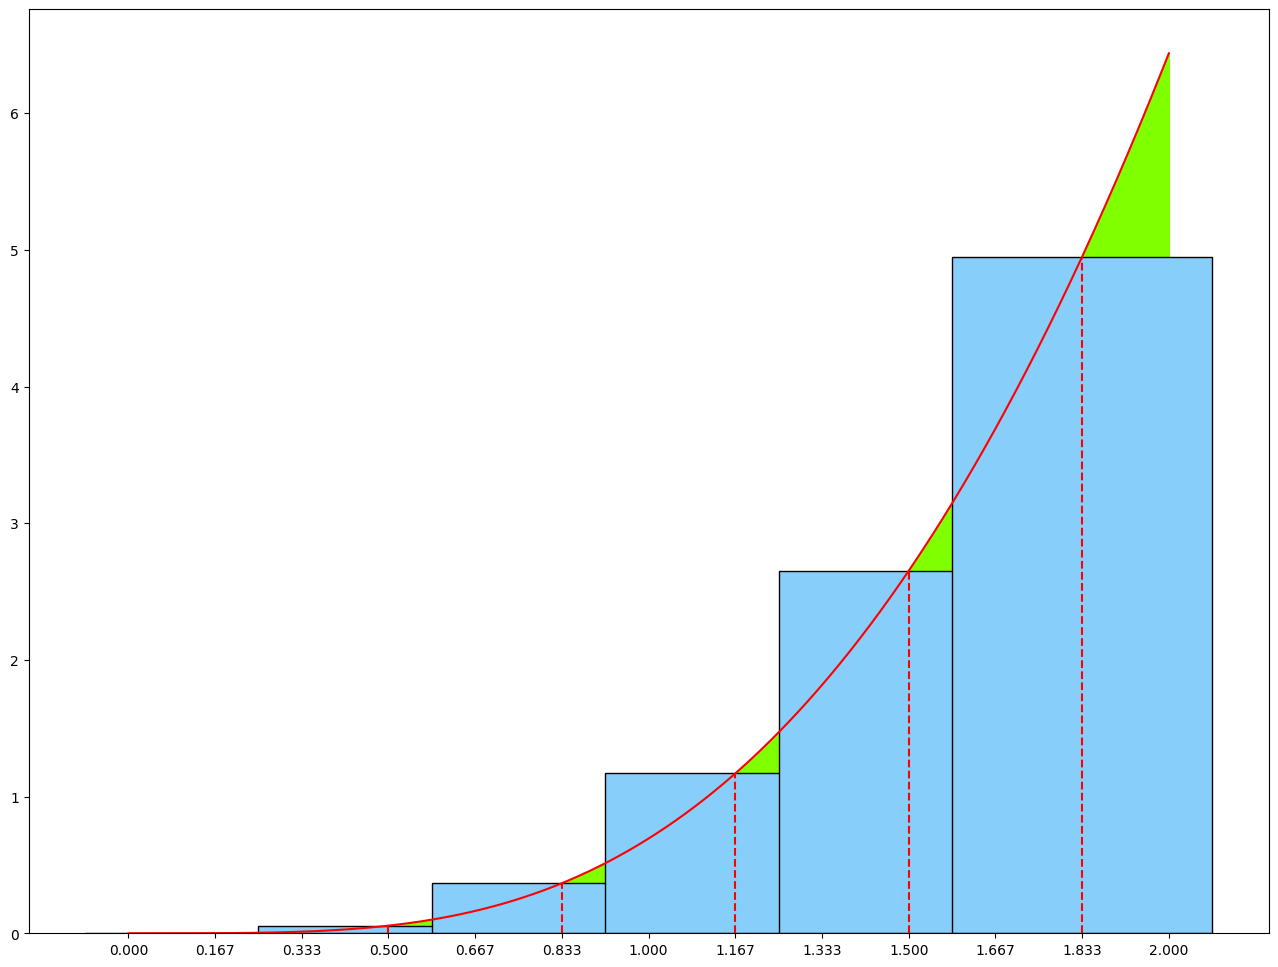

Version 2 :  4.59705629528127


In [22]:
f = lambda x: x ** 2 * np.log(x ** 2 + 1)
print("Version 1 : ", CompositeMidpoint(f, 0, 2, h=0.25, visualize=True))
print("Version 2 : ", CompositeMidpoint_(f, 0, 2, h=0.25, visualize=True))

### Simpson's Rule
Let $f\in C^4[a, b]$, $n$ be even, $h=\frac{(b-a)}{n}$, and $x_j=a+jh$, for each $j=0,1,\cdots n.$ There exists a $\mu\in(a, b)$ for which the __Composite Simpson's Rule__ for $n$ subintervals can be written with its error term as
$$
\int_{a}^bf(x)\,dx=\frac{h}{3}\biggl[f(a)+2\sum_{j=1}^{\frac{n}{2}-1}f(x_{2j})+4\sum_{j=1}^{\frac{n}{2}}f(x_{2j-1})+f(b)\biggr]-\frac{b-a}{180}h^4f^{(4)}(\mu)
$$

Remark: The following NewtonDiff function is just to interpolate the parabola used in the approximation of the definite integral by the _Simpson's Rule_

In [23]:
def CompositeSimpson(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           h:Union[float, int]=None,
           N:int=None, 
           visualize:bool=False) -> float:
    if (h is None) and (N is None):
        raise ValueError("h and N cannot be None at the same time")
    elif h is None:
        h = (b - a) / N
    elif N is None:
        N = int((b - a) / h)
    x = np.linspace(a, b, N + 1)

    approx = h * (func(a) + func(b)) / 3
    approx += h * (4 * np.sum(func(x[1:-1:2])) + 2 * np.sum(func(x[2:-1:2]))) / 3
    if visualize:
        plt.figure(figsize=(16, 12))
        x_ = np.linspace(a, b, 1000)
        plt.fill_between(x_, func(x_), color='chartreuse')
        plt.plot(x_, func(x_), 'r')
        for idx in range(N - 1):
            x_quad = [x[idx], x[idx + 1], x[idx + 2]]
            y_quad = [func(x[idx]), func(x[idx + 1]), func(x[idx + 2])]
            plt.scatter(x_quad, y_quad)
            plt.fill_between(x_quad, y_quad, color="lightskyblue", edgecolor="black")

        plt.show()
    return approx

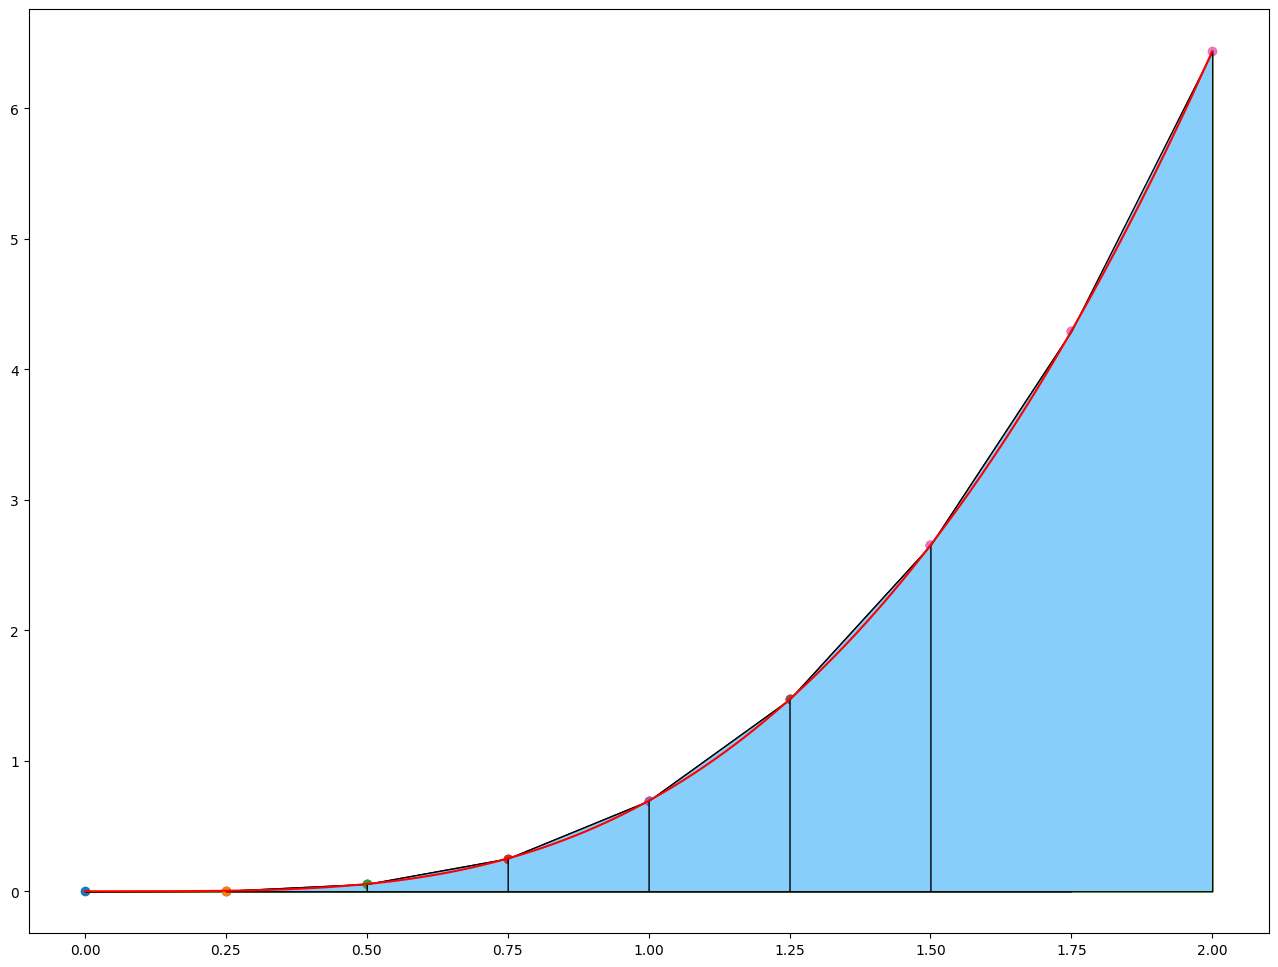

3.1093371265088647


In [24]:
print(CompositeSimpson(f, 0, 2, h=0.25, visualize=True))

### General Composite Integral
Given $n$ intervals and order of _Closed Newton-Cotes_, $m$ which means we dividing the interval $[a, b]$ into $n$ subintervals first then, $b_i=a_i+h$ where $h=\frac{b-a}{n}$. After that, these subintervals are divided into $m$ subintervals again to compute CNC on each subintervals (global $n$ subintervals), therefore for these $m$ intervals (came from one of the $n$ intervals), $h_i=\frac{b_i-a_i}{m} = \frac{h}{m}$. This approximation is expected to be more accurate for example _Composite Simpson's Rule_ stated above since the splitting of intervals is more precise.

In [207]:
def CompositeNewtonCotes(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           h:Union[float, int]=None,
           m:int=2,
           N:int=None,
           type:str="closed",
           visualize:bool=False
           ) -> float:
    if type not in ["closed", "open"]:
        raise ValueError("type must be either closed or open")
    if (h is None) and (N is None):
        raise ValueError("h and N cannot be None at the same time")
    elif h is None:
        h = (b - a) / N
    elif N is None:
        N = int((b - a) / h)

    x = np.linspace(a, b, N + 1)
    coef = closedNewtonCotesCoef(m) if type == "closed" else openNewtonCotesCoef(m)

    if visualize:
        # plt.figure(figsize=(16, 12))
        x_ = np.linspace(a, b, 1000)
        plt.fill_between(x_, func(x_), color='chartreuse')
        plt.plot(x_, func(x_), 'r')

    approx = 0

    for idx in range(N):
        h_ = h / m if type == "closed" else h / (m + 2)
        # Just reuse implementation before
        # if type == "closed":
        #     y_ = closedNewtonCotes(func, x[idx], x[idx + 1], m)
        # else:
        #     y_ = openNewtonCotes(func, x[idx], x[idx + 1], m)

        # For visualization
        x_ = np.linspace(x[idx], x[idx + 1], m + 1) if type == "closed" else np.linspace(x[idx] + h_, x[idx + 1] - h_, m + 1)
        y_ = func(x_)
        approx += np.sum(coef * y_) * h_
        if visualize:
            plt.scatter(x_, y_, s=30)
            plt.fill_between(x_, y_, edgecolor="black")
    if visualize:
        plt.show()

    return approx

Below are the version that $h=\frac{b-a}{n}$, for _Closed Newton Cotes Formula_ only, no further splitting is performed

In [ ]:
def CompositeClosedNewtonCotes(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           h:Union[float, int, None]=None,
           m:int=2,
           N:Union[int, None]=None,
           visualize:bool=False
           ) -> float:
    if (N is not None) and (not (N + 1) >= (2 * m + 1)):
        raise ValueError("N + 1 >= 2 * m + 1")
    if (h is None) and (N is None):
        raise ValueError("h and N cannot be None at the same time")
    elif h is None:
        h = (b - a) / N
    elif N is None:
        N = int((b - a) / h)

    x = np.linspace(a, b, N + 1)
    coef = closedNewtonCotesCoef(m)

    approx = 0
    for idx in range(0, N - m + 1, m):
        x_ = x[idx:idx + m + 1]
        y = func(x[idx:idx + m + 1])
        approx += np.sum(y * coef)
        if visualize:
            plt.scatter(x_, y, s=30)
            plt.fill_between(x_, y, edgecolor="black")
    if visualize:
        plt.show()
    return approx * h

In [214]:
# Exercise Set 4.4 Question 1
import pandas as pd
f = [
    # The first one is extra question
    lambda x: np.exp(x),
    lambda x: x * np.log(x), lambda x: x ** 3 *  np.exp(x),
    lambda x: 2 / (x ** 2 + 4), lambda x: x ** 2 * np.cos(x),
    lambda x: np.exp(2 * x) * np.sin(3 * x), lambda x: x / (x ** 2 + 4),
    lambda x: 1 / np.sqrt(x ** 2 - 4), lambda x: np.tan(x)
]

actual = [
    53.59815,
    0.636294361,
    19.92085296,
    0.7875398163,
    -6.283185307,
    24.60255242,
    0.477755723,
    0.604375587,
    0.960547179
]
left = [0, 1, -2, 0, 0, 0, 1, 3, 0]
right = [4, 2, 2, 2, np.pi, 2, 3, 5, 3 * np.pi / 8]
N = [4, 4, 4, 6, 6, 8, 8, 8, 8]
h = [0.25, 1 / 4, 1, 1 / 3, np.pi / 6, 1 / 4, 1 / 4, 1 / 4, 3 * np.pi / 16]

simpson = []
midpoint_2 = []
trapezoidal = [] 
closedNC_1 = []
closedNC_2 = []
closedNC_11 = []

openNC_0 = []
closedNC_1_ = []
closedNC_2_ = []
closedNC_11_ = []


for idx in range(len(f)):
    trapezoidal.append(CompositeTrapezoidal(f[idx], left[idx], right[idx], N=N[idx]))
    simpson.append(CompositeSimpson(f[idx], left[idx], right[idx], N=N[idx]))
    midpoint_2.append(CompositeMidpoint_(f[idx], left[idx], right[idx], N=N[idx]))
    closedNC_1.append(CompositeNewtonCotes(f[idx], left[idx], right[idx], N=N[idx], m=1))
    closedNC_2.append(CompositeNewtonCotes(f[idx], left[idx], right[idx], N=N[idx]))
    openNC_0.append(CompositeNewtonCotes(f[idx], left[idx], right[idx], N=N[idx], m=0, type="open"))
    
    closedNC_1_.append(CompositeClosedNewtonCotes(f[idx], left[idx], right[idx], N=N[idx], m=1))
    closedNC_2_.append(CompositeClosedNewtonCotes(f[idx], left[idx], right[idx], N=N[idx]))



pd.DataFrame(
    {
        "Actual":actual,
        "Trapezoidal":trapezoidal, 
        "CNC_1":closedNC_1, 
        "CNC_1_":closedNC_1_, 
        "Simpson":simpson, 
        "CNC_2":closedNC_2,
        "CNC_2_":closedNC_2_,
        "Midpoint":midpoint_2,
        "ONC_0":openNC_0,
    },
    index=["extra"] + list("abcdefgh")
)


,Actual,Trapezoidal,CNC_1,CNC_1_,Simpson,CNC_2,CNC_2_,Midpoint,ONC_0
extra,53.598149999999996850874595,57.991949867149479302952386,57.991949867149486408379744,57.991949867149486408379744,53.863845745864132652513945,53.616220796005812587736727,53.863845745864132652513945,49.824553379348600401499425,51.428356260433979230128898
a,0.636294361000000030514911,0.639900477687985969055262,0.639900477687985858032960,0.639900477687985858032960,0.636309829796949166791364,0.636295364639933858086351,0.636309829796949277813667,0.633096365057653209795774,0.634492808115908024646501
b,19.920852960000001274920578,31.365285650063754019356566,31.365285650063754019356566,31.365285650063754019356566,22.477125358234236074395085,20.123701982196884330278408,22.477125358234236074395085,11.156766835571190199516423,14.502910148263454814809847
c,0.787539816300000028448380,0.784240766617815832084659,0.784240766617815721062357,0.784240766617815721062357,0.785397945234010741444308,0.785398160076344886704192,0.785397945234010741444308,0.786700129598485675685993,0.785976856805609469525109
d,-6.283185307000000108246240,-6.428722218023162682243310,-6.428722218023162682243310,-6.428722218023163570421730,-6.274868388453120893188952,-6.282686619625665436217332,-6.274868388453120893188952,-6.112736349863236995361149,-6.209668820426916369115133
e,24.602552419999998534194674,-13.575979391799387840933377,-13.575979391799389617290217,-13.575979391799389617290217,-14.183341561446695777704008,-14.212314929230730697895524,-14.183341561446695777704008,-14.998476941632310044383303,-14.530482697946402126376597
f,0.477755723000000021016831,0.476976866514718378375903,0.476976866514718322864752,0.476976866514718322864752,0.477754646284790251975494,0.477755662852286044905981,0.477754646284790196464343,0.478751520059702673215440,0.478145061021069794904292
g,0.604375587000000047410708,0.605497514542146064719930,0.605497514542146175742232,0.605497514542146175742232,0.604394076297428139987744,0.604376831607897679887742,0.604394076297428139987744,0.602960750918011378907124,0.603816490140773209915892
h,0.960547178999999973214585,0.970926306679130157739621,0.970926306679130268761924,0.970926306679130268761924,0.961055398495535562197745,0.960585061860279809664576,0.961055398495535451175442,0.947868369632215879150294,0.955414439450854802160507


## Chapter 4.5 Romberg Integration
By an alternative method it can be shown that if $f\in C^{\infty}[a, b]$, the __Composite Trapezoidal Rule__ can also be written with an error term in the form of
$$
\int_{a}^{b}f(x)\,dx=\frac{h}{2}\biggl[
    f(a)+2\sum_{j=1}^{n-1}f(x_j)+f(b)
\biggr]+K_1h^2+K_2h^4+K_3h^6+\cdots
$$
where each $K_i$ is a constant depends only on $f^{(2i-1)}(a)$ and $f^{(2i-1)}(b)$
This is an obvious candidate for extrapolation. This results in a technique known as __Romberg Integration__

To obtain the __Romberg Integration__ for __Composite Trapezoidal Rule__, let $h_k=\frac{(b-a)}{2^{k-1}}$
$$
R_{k, 1}=\frac{1}{2}\biggl[
    R_{k-1, 1}+h_{k-1}\sum_{i=1}^{2^{k-2}}f(a+(2i-1)h_k)
\biggr]
$$
for each $k=2,3,\cdots,n$
$$
R_{k, j}=R_{k, j-1}+\frac{R_{k, j-1}-R_{k-1, j-1}}{4^{j-1}-1}
$$
for $k=j,j+1,\cdots$

The following codes implement the algorithm in two different way:

i)Version 1: Plain version without optimize the storage

ii)Version 2: Modified version with storage optimization with using just two rows

In [ ]:
# Version 1
def Romberg(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           N:int=None) -> np.ndarray[Union[float, int], Any]:
    R = np.zeros((N, N))
    h = b - a
    R[0][0] = h * (func(a) + func(b)) / 2

    for idx in range(1, N):
        R[idx, 0] = R[idx - 1, 0]
        for jdx in range(1, int(2 ** (idx - 1)) + 1):
            R[idx, 0] += h * func(a + (jdx - 0.5) * h)
        R[idx, 0] /= 2
        h /= 2
    for idx in range(1, N):
        for jdx in range(idx, N):
            R[jdx, idx] = R[jdx, idx - 1] + (R[jdx, idx - 1] - R[jdx - 1, idx - 1]) / (4 ** idx - 1)
    return R

In [ ]:
# Version 2
def Romberg_(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           N:int=None) -> np.ndarray[Union[float, int], Any]:
    R = np.zeros((2, N))
    h = b - a
    R[0][0] = h * (func(a) + func(b)) / 2

    for idx in range(1, N):
        R[1, 0] = R[0, 0]
        for jdx in range(1, int(2 ** (idx - 1)) + 1):
            R[1, 0] += h * func(a + (jdx - 0.5) * h)
        R[1, 0] /= 2
        h /= 2
        for jdx in range(1, idx + 1):
            R[1, jdx] = R[1, jdx - 1] + (R[1, jdx - 1] - R[0, jdx - 1]) / (4 ** jdx - 1)
        R[0] = R[1]
    return R[-1, :]

In [ ]:
f = lambda x: np.sin(x)
print(Romberg(f, 0, np.pi, 6))
print(Romberg_(f, 0, np.pi, 6))

[[1.92367069e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.57079633e+00 2.09439510e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.89611890e+00 2.00455975e+00 1.99857073e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.97423160e+00 2.00026917e+00 1.99998313e+00 2.00000555e+00
  0.00000000e+00 0.00000000e+00]
 [1.99357034e+00 2.00001659e+00 1.99999975e+00 2.00000002e+00
  1.99999999e+00 0.00000000e+00]
 [1.99839336e+00 2.00000103e+00 2.00000000e+00 2.00000000e+00
  2.00000000e+00 2.00000000e+00]]
[1.99839336 2.00000103 2.         2.         2.         2.        ]


## Chapter 4.6 Adaptive Quadrature Methods
If the approximation error for an integral on a given interval is to be evenly distributed,
a smaller step size is needed for the large-variation regions than for those with less variation.
An efficient technique for this type of problem should predict the amount of functional variation and adapt the step size as necessary. These methods are called __Adaptive quadrature
methods__.

### General Scheme for Adaptive Quadrature Methods

$Q\approx\int_a^bf(x)\,dx$

$\epsilon\approx\biggl|Q-\int_a^bf(x)\,dx\biggr|$

if $\epsilon>\tau$ then
$m=\frac{(b + a)}{2}$

$Q=integrate(f, a, m, \frac{\tau}{2}) + integrate(f, m, b, \frac{\tau}{2})$

The important components are the quarature rule 

$Q\approx\int_a^bf(x)\,dx$

the error estimator

$\epsilon\approx\biggl|Q-\int_a^bf(x)\,dx\biggr|$

and the logic for deciding which interval to subdivide, and when to terminate


### Adaptive Simpson's Rule


In [ ]:
def AdaSimpson(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           eps:float=10e-6,
           visualize:bool=False) -> Tuple[np.ndarray[Union[float, int], Any], int, int]:
    
    cnt = 1
    num_eval = 2

    if visualize:
        midpoints = [a]

    def Simpson_(func_, a_, b_, fa_, fb_) -> Tuple[float, float, float]:
        nonlocal num_eval
        num_eval += 1
        m = a_ + (b_ - a_) / 2
        fm = func_(m)
        return (m, fm, (b_ - a_) * (fa_ + 4 * fm + fb_) / 6)

    def divide(func_, a_, fa_, b_, fb_, eps, m, fm, whole, visualize) -> float:
        left_mid, f_left_mid, left_simp = Simpson_(func_, a_, m, fa_, fm)
        right_mid, f_right_mid, right_simp = Simpson_(func_, m, b_, fm, fb_)
        delta = left_simp + right_simp - whole
        # This bound is chosen conservatively to compensate for
        # error in the assumption f''''(\xi).
        # In problems where f'''' is known to be widely
        # varying, this bound should be decreased even further
        if (abs(delta) < eps * 15):
            nonlocal cnt
            cnt += 1
            return (left_simp + right_simp + delta / 15)  
        else:
            if visualize:
                midpoints.append(m)

            return (divide(func_, a_, fa_, m, fm, eps / 2, left_mid, f_left_mid, left_simp, visualize) + 
                    divide(func_, m, fm, b_, fb_, eps / 2, right_mid, f_right_mid, right_simp, visualize)
            )
    
    fa = func(a)
    fb = func(b)
    t = Simpson_(func, a, b, fa, fb)
    approx = divide(func, a, fa, b, fb, eps, t[0], t[1], t[2], visualize)
    if visualize:
        midpoints.append(b)
        plt.figure(figsize=(16, 12))
        x = np.linspace(a, b, 500)
        plt.plot(x, func(x))
        plt.scatter(midpoints, func(np.array(midpoints)))
        plt.xticks(midpoints, rotation=45)
        plt.show()
    return (approx, cnt, num_eval)

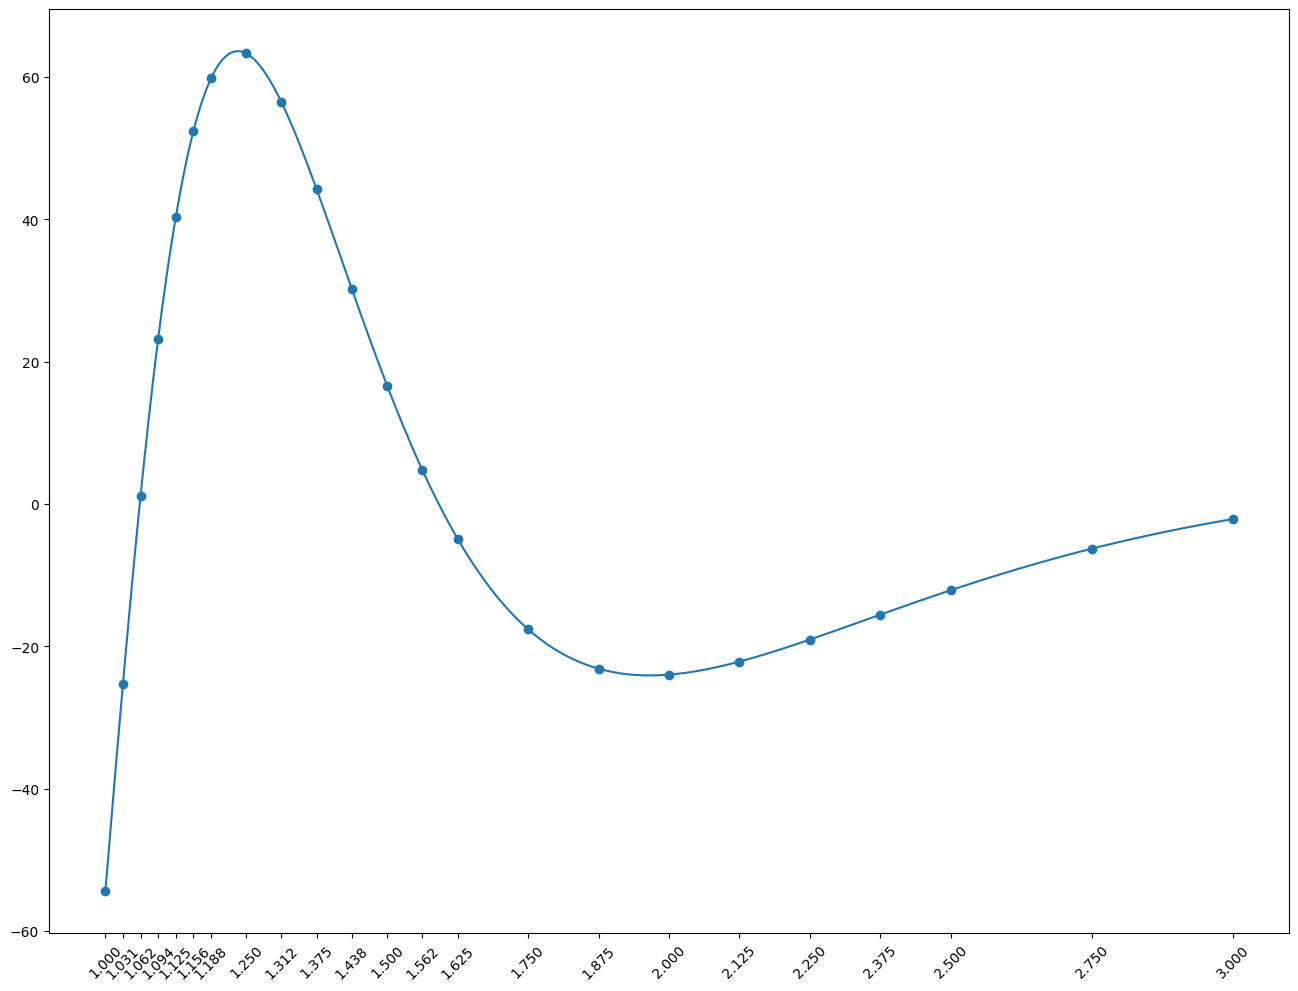

(-1.4260246884442598, 23, 89)

In [ ]:
f = lambda x: 100 / (x ** 2) * np.sin(10 / x)
AdaSimpson(f, 1.0, 3.0, 1e-4, visualize=True)

### Adaptive Trapezoidal Rule
Mimic the method deriving the _Adaptive Simpson Rule_, we get

In [ ]:
def AdaTrapezoidal(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           eps:float=10e-6,
           visualize:bool=False) -> Tuple[np.ndarray[Union[float, int], Any], int, int]:
    
    cnt = 1
    num_eval = 2

    if visualize:
        midpoints = [a]

    def Trapezoidal_(a_, b_, fa_, fb_) -> Tuple[float, float, float]:
        m = a_ + (b_ - a_) / 2
        fm = func(m)
        nonlocal num_eval
        num_eval += 1
        return (m, fm, (fa_ + fb_) * (b_ - a_) / 2)

    def divide(a_, fa_, b_, fb_, eps, m, fm, whole) -> float:
        left_mid, f_left_mid, left_trap = Trapezoidal_(a_, m, fa_, fm)
        right_mid, f_right_mid, right_trap = Trapezoidal_(m, b_, fm, fb_)
        delta = left_trap + right_trap - whole
        if (abs(delta) < eps * 3):
            nonlocal cnt
            cnt += 1
            return (left_trap + right_trap + delta / 3)  
        else:
            if visualize:
                midpoints.append(m)

            return (divide(a_, fa_, m, fm, eps / 2, left_mid, f_left_mid, left_trap) + 
                    divide(m, fm, b_, fb_, eps / 2, right_mid, f_right_mid, right_trap)
            )
    
    fa = func(a)
    fb = func(b)
    t = Trapezoidal_(a, b, fa, fb)
    approx = divide(a, fa, b, fb, eps, t[0], t[1], t[2])
    if visualize:
        midpoints.append(b)
        plt.figure(figsize=(16, 12))
        x = np.linspace(a, b, 500)
        plt.plot(x, func(x))
        plt.scatter(midpoints, func(np.array(midpoints)))
        plt.xticks(midpoints, rotation=45)
        plt.show()
    return (approx, cnt, num_eval)

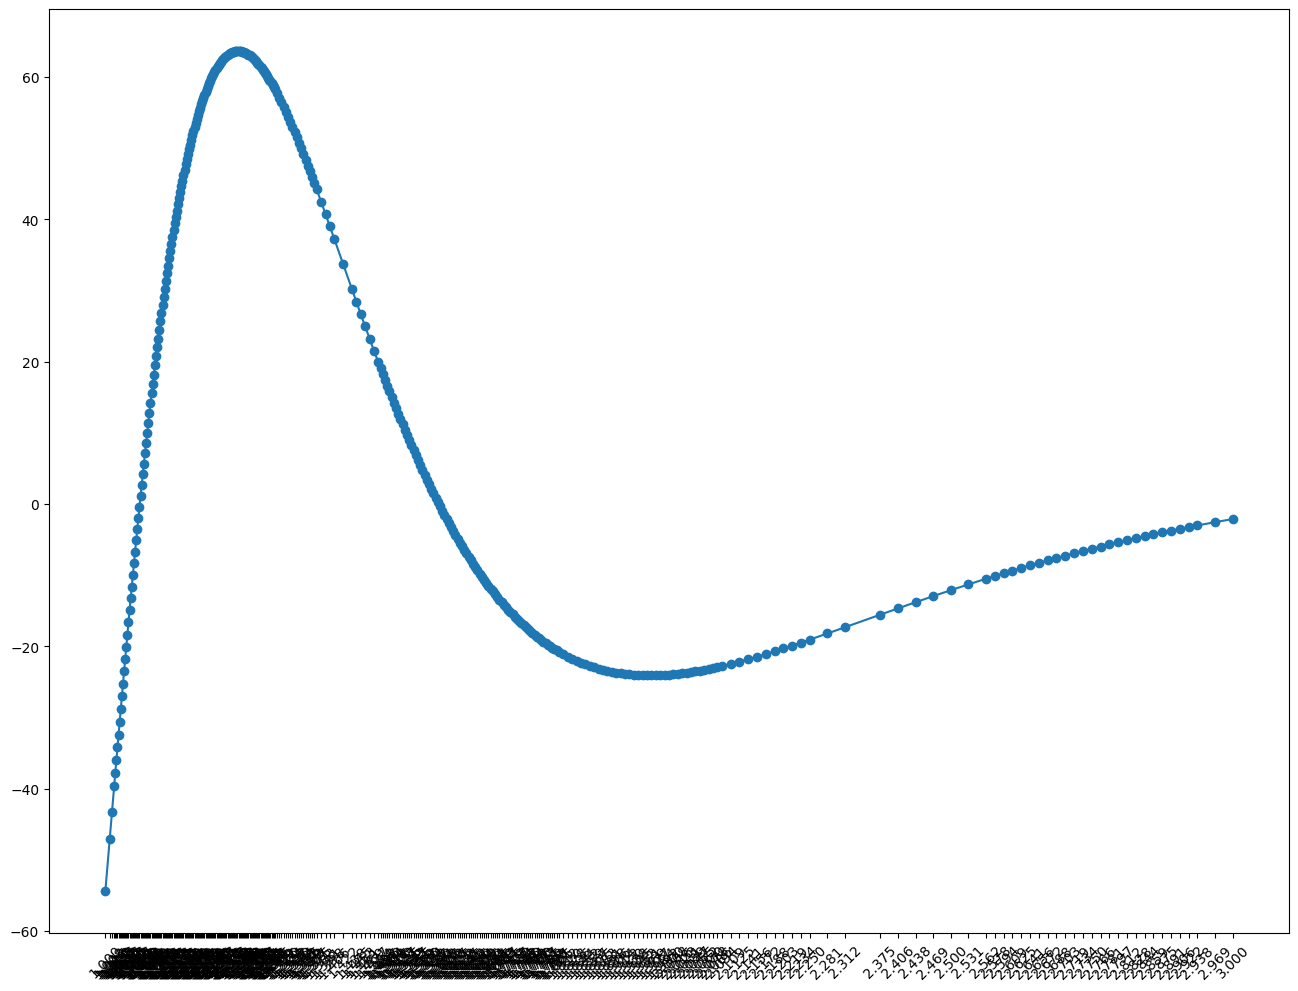

(-1.4260243585072327, 345, 1377)

In [ ]:
f = lambda x: 100 / (x ** 2) * np.sin(10 / x)
AdaTrapezoidal(f, 1.0, 3.0, 1e-3, visualize=True)

### Adaptive Closed Newton-Cotes Formulae

To derive the coefficient of epsilon for general case, suppose $E = \alpha h^m$ then the error of its composite will be $E_C=\alpha h^m \frac{n}{k}$ where $k$ is the number of points in _Newton-Cotes Formulae_ and $n$ should be divisible by $k$. Considering divide the interval into $2$ subintervals, this causes the $h$ in $E_C$ becomes $\frac{h}{2}$ and $n$ becomes $2n$ but in this case $n=k$ since we are just splitting the original interval separated by $k$ points into two subintervals therefore, we have
$$
E-E_C=\alpha h^m-\alpha\biggl(\frac{h}{2}\biggr)^m\biggl(\frac{2n}{k}\biggr)=\alpha h^m\biggl(1-\frac{1}{2^{m-1}}\biggr)=\alpha h^m\biggl(\frac{2^{m-1}-1}{2^{m-1}}\biggr)
$$
But since we only need the numerator of the above equation, we try to divide it by $E_C$
$$
\frac{E-E_C}{E_C}=\frac{\alpha h^m\bigl(\frac{2^{m-1} - 1}{2^{m-1}}\bigr)}{\alpha\bigl(\frac{h}{2}\bigr)^m\bigl(\frac{2n}{k}\bigr)}=2^{m-1}\biggl(\frac{2^{m-1} - 1}{2^{m-1}}\biggr)=2^{m-1}-1
$$

In [ ]:
def AdaClosedNewtonCotes(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
           a:Union[float, int],
           b:Union[float, int],
           n:int,
           eps:float=10e-6,
           visualize:bool=False) -> Tuple[np.ndarray[Union[float, int], Any], int, int]:
    '''
    
    Re
    '''
    cnt = 1
    num_eval = 0
    h_power = n + 2
    if n % 2 == 0:
        h_power += 1
    eps_coef = (2 ** (h_power - 1) - 1)
    coef = closedNewtonCotesCoef(n)

    if visualize:
        midpoints = [a]

    def ClosedNewtonCotes_(a_, b_) -> Tuple[float, float]:
        n_ = n
        h = (b_ - a_) / n_
        n_ += 1
        x = np.linspace(a_, b_, n_)
        y = func(x)

        m = a_ + (b_ - a_) / 2
        nonlocal num_eval
        num_eval += n
        return (m, np.sum(coef * y) * h)

    

    def divide(a_, b_, eps, m, whole) -> float:
        nonlocal cnt
        left_mid, left_newton = ClosedNewtonCotes_(a_, m)
        right_mid, right_newton = ClosedNewtonCotes_(m, b_)
        delta = left_newton + right_newton - whole
        if (abs(delta) < eps * eps_coef):
            cnt += 1
            return (left_newton + right_newton + delta / eps_coef)  
        else:
            if visualize:
                midpoints.append(m)
            return (divide(a_, m, eps / 2, left_mid, left_newton) + 
                    divide(m, b_, eps / 2, right_mid, right_newton)
            )
    
    t = ClosedNewtonCotes_(a, b)
    approx = divide(a, b, eps, t[0], t[1])
    if visualize:
        midpoints.append(b)
        plt.figure(figsize=(16, 12))
        x = np.linspace(a, b, 500)
        plt.plot(x, func(x))
        plt.scatter(midpoints, func(np.array(midpoints)))
        plt.xticks(midpoints, rotation=45)
        plt.show()
    return (approx, cnt, num_eval)


In [ ]:
f = lambda x: (100 / x ** 2) * np.sin(10 / x)
a = 1
b = 3
tol = 10 ** (-4)
print("Adaptive Trapezoidal Rule")
print(AdaTrapezoidal(f, a, b, tol))
print(AdaClosedNewtonCotes(f, a, b, 1, tol))
print("Adaptive Simpson's Rule")
print(AdaSimpson(f, a, b, tol))
print(AdaClosedNewtonCotes(f, a, b, 2, tol))
print("Adaptive 3-8 Simpson's Rule")
print(AdaClosedNewtonCotes(f, a, b, 3, tol))
print("Adaptive Rule")
print(AdaClosedNewtonCotes(f, a, b, 4, tol))
print(AdaClosedNewtonCotes(f, a, b, 5, tol))
print(AdaClosedNewtonCotes(f, a, b, 6, tol))
print(AdaClosedNewtonCotes(f, a, b, 7, tol))
print(AdaClosedNewtonCotes(f, a, b, 8, tol))
print(AdaClosedNewtonCotes(f, a, b, 9, tol))
print(AdaClosedNewtonCotes(f, a, b, 10, tol))


Adaptive Trapezoidal Rule
(-1.4260243972490407, 1064, 4253)
(-1.4260243972490407, 1064, 4251)
Adaptive Simpson's Rule
(-1.4260246884442598, 23, 89)
(-1.4260246884442616, 23, 174)
Adaptive 3-8 Simpson's Rule
(-1.4260245457048857, 21, 237)
Adaptive Rule
(-1.4260242813353088, 8, 108)
(-1.426038652060603, 6, 95)
(-1.426065628168221, 4, 66)
(-1.4260496674839889, 4, 77)
(-1.426347985997193, 3, 56)
(-1.4262350167398186, 3, 63)
(-1.4301938924973285, 2, 30)


In [ ]:
f = [
    lambda x: np.exp(2 * x) * np.sin(3 * x),
    lambda x: np.exp(3 * x) * np.sin(2 * x),
    lambda x: 2 * x * np.cos(2 * x) - (x - 2) ** 2,
    lambda x: 4 * x * np.cos(2 * x) - (x - 2) ** 2,
    lambda x: np.sin(x ** 2)
]
a = [1, 1, 0, 0, 0]
b = [3, 3, 5, 5, 1]

n = 20
approx = [[] for _ in range(len(f))]
for idx in range(len(f)):
    for jdx in range(1, n):
        approx[idx].append(AdaClosedNewtonCotes(f[idx], a[idx], b[idx], jdx + 1, 10 ** (-10))[0])
pd.DataFrame({
    idx + 1:approx[idx] for idx in range(len(f))
})

,1,2,3,4,5
0,108.555281212127752610285825,-1724.966983009345085520180874,-15.306307985651734782095446,-18.945949304636815924141047,0.310268301723138573144922
1,108.555281212127724188576394,-1724.966983009344858146505430,-15.306307985651736558452285,-18.945949304636808818713689,0.310268301723192641006221
2,108.555281212127368917208514,-1724.966983009344858146505430,-15.306307985651713465813373,-18.945949304636808818713689,0.310268301723405859338101
3,108.555281212127496814900951,-1724.966983009344403399154544,-15.306307985651722347597570,-18.945949304636794607858974,0.310268301725271589130983
4,108.555281212127084700114210,-1724.966983009351906730444171,-15.306307985651121938985852,-18.945949304635576027067145,0.310268301719174688368952
5,108.555281212127354706353799,-1724.966983009350997235742398,-15.306307985651386616154923,-18.945949304636091170550571,0.310268301720840022905890
6,108.555281212129955292766681,-1724.966983009355772082926705,-15.306307985651137926197407,-18.945949304635544052644036,0.310268301698566673074708
7,108.555281212128292622765002,-1724.966983009339401178294793,-15.306307985651248060321450,-18.945949304635874455016165,0.310268301707670057787425
8,108.555281212140357638418209,-1724.966983009348041377961636,-15.306307985651635306112439,-18.945949304636680921021252,0.310268301723478912013121
9,108.555281212146482516800461,-1724.966983009501973356236704,-15.306307985653045733442923,-18.945949304638453725146974,0.310268301723473360897998


## Chapter 4.7 Gaussian Quadrature
Gaussian quadrature chooses the points for evaluation in an optimal, rather than equally spaced  way. The nodes $x_1, x_2,\cdots , x_n$ in the interval $[a, b]$ and coefficients $c_1, c_2,\cdots , c_n$, are
chosen to minimize the expected error obtained in the approximation. 
$$\int_a^{b}f(x)\,dx\approx\sum_{i=1}^nc_if(x_i)$$

To measure this accuracy, we assume that the best choice of these values produces the exact
result for the largest class of polynomials, that is, the choice that gives the greatest degree
of precision.

### Legendre Polynomials
- For each $n$, $P_n(x)$ is a monic polynomial of degree $n$.
- $\int_{-1}^1P(x)P_n(x)\,dx=0$ for any polynomial $P(x)$ that has degree less than $n$

For example, the first few _Legendre Polynomials_ are
- $P_0(x)=0$
- $P_1(x)=x$
- $P_2(x)=x^2-\frac{1}{3}$
- $P_3(x)=x^3-\frac{3}{5}x$
- $P_4(x)=x^4-\frac{6}{7}x^2+\frac{3}{35}$

The roots of these polynomials are distinct, lie in the interval (−1, 1), have a symmetry
with respect to the origin. The nodes $x_1, x_2,\cdots, x_n$ needed to produce an integral approximation formula that gives exact results for any polynomial of degree less than $2n$ are the roots of the $n$ th-degree Legendre polynomial.

Suppose that $x_1, x_2,\cdots, x_n$ are the roots of the $n$ th Legendre polynomial $P_n(x)$ and that for
each $i = 1, 2, \cdots , n$, the numbers $c_i$ are defined by
$$
c_i = \int_{-1}^{1}\prod_{\substack{j=1\\ i\neq j}}^n\frac{x-x_j}{x_i-x_j}\,dx
$$
If $P(x)$ is any polynomial of degree less than $2n$, then 
$$
\int_{-1}^{1}P(x)\,dx=\sum_{i=1}^nc_iP(x_i)
$$

An integral $\int_a^bf(x)\,dx$ over an arbitrary $[a, b]$ needed to be transformed into an integral over $[-1, 1]$, by using the change of variables 
$$
t=\frac{2x - a - b}{b - a}\Longleftrightarrow x=\frac{1}{2}[(b-a)t+a+b]
$$

Refer to [Gaussian Quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature#Other_forms) for more different types of quadracture and polynomials

In [ ]:
def GaussianLegendre(func:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    a:Union[float, int],
                    b:Union[float, int],
                    n:int):
    degree = np.zeros(n + 1)
    degree[-1] = 1
    roots = np.polynomial.Legendre(degree).roots()
    coef = np.zeros(n, dtype=float)
    # The coefficient of transformation has been included
    transformed_func = lambda x: func(((b - a) * x + (b + a)) / 2) * (b - a) / 2
    p = transformed_func(roots)
    for idx in range(n):
        # This function is called to modify the coefficients but we do not need
        # the return value
        integPolynomial(idx, roots, coef)
    return np.sum(coef * p)

In [ ]:
# Example 1
f = lambda x: np.exp(x) * np.cos(x)
GaussianLegendre(f, -1, 1, 3)

1.9333904692642974

In [ ]:
# Example 2
f = lambda x: x ** 6 - x ** 2 * np.sin(2 * x)
print(closedNewtonCotes(f, 1, 3, 1))
print(openNewtonCotes(f, 1, 3, 1))
print(GaussianLegendre(f, 1, 3, 2))

print(closedNewtonCotes(f, 1, 3, 2))
print(openNewtonCotes(f, 1, 3, 2))
print(GaussianLegendre(f, 1, 3, 3))

731.6054420569646
188.785668300116
306.81993449592
333.2380939939638
303.59120227719205
317.26415173382895


In [ ]:
import pandas as pd
# Exercise 1
f = [
    lambda x: x ** 2 * np.log(x),
    lambda x: x ** 2 * np.exp(-x),
    lambda x: 2 / (x ** 2 - 4),
    lambda x: x ** 2 * np.sin(x),
    lambda x: np.exp(3 * x) * np.sin(2 * x),
    lambda x: (2 * x) / (x ** 2 - 4),
    lambda x: x / np.sqrt(x ** 2 - 4),
    lambda x: np.cos(x) ** 2
]

a = [1, 0, 0, 0, 0, 1, 3, 0]
b = [1.5, 1, 0.35, np.pi / 4, np.pi / 4, 1.6, 3.5, np.pi / 4]

n2 = []
n3 = []
n4 = []
n5 = []

for idx in range(len(f)):
    n2.append(GaussianLegendre(f[idx], a[idx], b[idx], 2))
    n3.append(GaussianLegendre(f[idx], a[idx], b[idx], 3))
    n4.append(GaussianLegendre(f[idx], a[idx], b[idx], 4))
    n5.append(GaussianLegendre(f[idx], a[idx], b[idx], 5))
n = [n2, n3, n4, n5]

pd.DataFrame({
    f"N = {idx + 2}": n[idx] for idx in range(len(n))
})
    

,N = 2,N = 3,N = 4,N = 5
0,0.192268706370917558112765,0.192259377256879027129344,0.192259357804863306729004,0.192259357733142011159799
1,0.159410430966378968697938,0.160595386808919243781801,0.160602777514684852411264,0.160602794123437558893031
2,-0.176818989454911895675693,-0.176820017886220565150879,-0.176820020116895487705122,-0.176820020121778387345302
3,0.089263015657132877000990,0.088753853617856690028098,0.088755286163101493324135,0.088755284434109626978682
4,2.591324715654924837338058,2.589258003115426198803561,2.588632746532254280680263,2.588628618667189851265675
5,-0.730723036271919590411983,-0.733799022256458099988663,-0.733960393441890790455773,-0.733968724860458499037463
6,0.636196564962796640152476,0.636213195913082341093059,0.636213344399087610270271,0.636213345756461379210123
7,0.642317235049752799369571,0.642701112087598724897930,0.642699075998003022114347,0.642699081708615449493038


## Chapter 4.8 Multiple Integrals
Apply the techniques of numerical integration to the inner integral first then outer.

In [ ]:
def DoubleCNewtonCotes(func:Callable[[Union[float, int, np.ndarray], Union[float, int, np.ndarray]], Union[float, int]],
                    a:Union[float, int],
                    b:Union[float, int],
                    c:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    d:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    m:int, n:int, M:int, N:int) -> float:
    if M % m :
        raise ValueError(f"M must be divisible by m but {M % m=}")
    if N % n:
        raise ValueError(f"N must be divisible by n but {N % n=}")
    x = np.linspace(a, b, M + 1)
    coef = closedNewtonCotesCoef(m)
    h = (b - a) / M
    y = []
    for idx in range(M + 1):
        func_1 = lambda y: func(x[idx], y)
        y.append(CompositeClosedNewtonCotes_(func_1, c(x[idx]), d(x[idx]), None, n, N))
    approx = 0
    for idx in range(0, M - m + 1, m):
        approx += np.sum(coef * y[idx:idx + m + 1])
    return approx * h

def TripleCNewtonCotes(func:Callable[[Union[float, int, np.ndarray], 
                                      Union[float, int, np.ndarray], 
                                      Union[float, int, np.ndarray]], Union[float, int]],
                    a:Union[float, int],
                    b:Union[float, int],
                    c:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    d:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    alpha:Callable[[Union[float, int, np.ndarray], Union[float, int, np.ndarray]], Union[float, int]],
                    beta:Callable[[Union[float, int, np.ndarray], Union[float, int, np.ndarray]], Union[float, int]],
                    m:int, n:int, p:int,  M:int, N:int, P:int) -> float:
    if M % m :
        raise ValueError(f"M must be divisible by m but {M % m=}")
    if N % n:
        raise ValueError(f"N must be divisible by n but {N % n=}")
    if P % p:
        raise ValueError(f"P must be divisible by p but {P % p=}")
    x = np.linspace(a, b, M + 1)
    x_coef = closedNewtonCotesCoef(m)
    y_coef = closedNewtonCotesCoef(n)
    x_h = (b - a) / M
    y = []
    for idx in range(M + 1):
        z = []
        y_h = (d(x[idx]) - c(x[idx])) / N
        y_ = np.linspace(c(x[idx]), d(x[idx]), N + 1)
        for jdx in range(N + 1):
            func_2 = lambda z: func(x[idx], y_[jdx], z)
            z.append(CompositeClosedNewtonCotes_(func_2, alpha(x[idx], y_[jdx]), beta(x[idx], y_[jdx]), None, p, P))
        y_approx = 0
        for jdx in range(0, N - n + 1, n):
            y_approx += np.sum(y_coef * z[jdx:jdx + n + 1])
        y.append(y_approx * y_h)
    x_approx = 0
    for idx in range(0, M - m + 1, m):
        x_approx += np.sum(x_coef * y[idx:idx + m + 1])
    return x_approx * x_h


In [ ]:
m = 4
n = 8
b = np.pi / 4
a = 0
c = lambda x: np.sin(x)
d = lambda x: np.cos(x)
f = lambda x, y: 2 * y * np.sin(x) + np.cos(x) ** 2

DoubleCNewtonCotes(f, a, b, c, d, 2, 2, 4, 4)

0.5119875440121252

In [ ]:
a, b = 0, 1
c, d = lambda x: 0, lambda x: 1
alpha, beta = lambda x, y: -x * y, lambda x, y: x * y
f = lambda x, y, z: np.exp(x ** 2 + y ** 2)
TripleCNewtonCotes(f, a, b, c, d, alpha, beta, 2, 3, 4, 4, 9, 16)

1.4797384603018011

In [ ]:
def DoubleGaussianLegendre(func:Callable[[Union[float, int, np.ndarray], Union[float, int, np.ndarray]], Union[float, int]],
                    a:Union[float, int],
                    b:Union[float, int],
                    c:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    d:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    m:int, n:int) -> float:
    degree_x = np.zeros(m + 1)
    degree_x[-1] = 1
    degree_y = np.zeros(n + 1)
    degree_y[-1] = 1
    
    roots_x = np.polynomial.Legendre(degree_x).roots()
    roots_y = np.polynomial.Legendre(degree_y).roots()
    coef_x = np.zeros(m, dtype=float)
    coef_y = np.zeros(n, dtype=float)
    approx_x = 0
    
    h_1 = (b - a) / 2
    h_2 =  h_1 + a
    for idx in range(m):
        approx_y = 0
        x = integPolynomial(idx, roots_x, coef_x, alpha=h_1, beta=h_2)
        c_, d_ = c(x), d(x)
        k_1 = (d_ - c_) / 2
        k_2 = k_1 + c_
        for jdx in range(n):
            y = integPolynomial(jdx, roots_y, coef_y, alpha=k_1, beta=k_2)
            approx_y += coef_y[jdx] * func(x, y)
        approx_x += coef_x[idx] * k_1 * approx_y
    return h_1 * approx_x

In [ ]:
# Illustration
f = lambda x, y: np.exp(y / x)
c = lambda x: x ** 3
d = lambda x: x ** 2
DoubleGaussianLegendre(f, 0.1, 0.5,c, d, 5, 5)

0.03330556611867535

In [ ]:
# Exercise 5
f = [
    lambda x, y: x * y ** 2,
    lambda x, y: np.exp(y - x),
    lambda x, y: x ** 2 + y ** 3,
    lambda x, y: x ** 2 + np.sqrt(y),
]
a = [
    2.1, 0, 2, 1
]
b = [
    2.5, 0.5, 2.2, 1.5
]
c = [
    lambda x: 1.2, lambda x: 0,
    lambda x: x, lambda x: 0
]
d = [
    lambda x: 1.4,
    lambda x: 0.5,
    lambda x: 2 * x,
    lambda x: x
]

for _ in range(len(f)):
    print(DoubleGaussianLegendre(f[_], a[_], b[_], c[_], d[_], 2, 2))

0.3115733333333331
0.2552446029338543
16.50863333333335
1.4888745284660247


In [ ]:
import pandas as pd

# Exercise 7
f = [
    lambda x, y: 2 * y * np.sin(x) + np.cos(x) ** 2,
    lambda x, y: np.log(x * y),
    lambda x, y: x ** 2 + y ** 3,
    lambda x, y: y ** 2 + x ** 3,
    lambda x, y: np.cos(x),
    lambda x, y: np.cos(y),
    lambda x, y: 1 / (np.sqrt(1 - y ** 2)),
    lambda x, y: y * np.sin(x) + x * np.cos(y)
]
a = [
    0, 1, 0, 0, 0, 0, 0, -np.pi
]
b = [
    np.pi / 4, np.exp(1), 1, 1, np.pi, np.pi, np.pi / 4, 3 * np.pi / 2
]
c = [
    lambda x: np.sin(x), lambda x: 1,
    lambda x: x, lambda x: x,
    lambda x: 0, lambda x: 0,
    lambda x: 0, lambda x: 0
]
d = [
    lambda x: np.cos(x), lambda x: x,
    lambda x: 2 * x, lambda x: 2 * x,
    lambda x: x, lambda x: x,
    lambda x: np.sin(x), lambda x: 2 * np.pi
]

df = {}

m = [3, 4, 3, 4]
n = [3, 3, 4, 4]
for idx in range(len(m)):
    t = []
    for jdx in range(len(f)):
        t.append(DoubleGaussianLegendre(f[jdx], a[jdx], b[jdx], c[jdx], d[jdx], m[idx], n[idx]))
    df[f"m={m[idx]}, n={n[idx]}"] = t
pd.DataFrame(df)

,"m=3, n=3","m=4, n=3","m=3, n=4","m=4, n=4"
0,0.511865539945295822121807,0.511844502852886962251944,0.511865539945295933144109,0.511844502852886962251944
1,1.718163198881260678163585,1.718301540689977313647319,1.718138610795775234052485,1.718276985021418568067020
2,0.999999999999999777955395,1.000000000000000444089210,1.000000000000000444089210,1.000000000000000666133815
3,0.783333333333333214909544,0.783333333333333658998754,0.783333333333333436954149,0.783333333333333881043359
4,-1.991877754951479229106326,-2.000124241081804754571749,-1.991877754951479451150931,-2.000124241081805198660959
5,2.001494184469370996026782,2.000079764804151505330765,2.001388044663227727681942,1.999983507663209758575817
6,0.308415148918010584289107,0.308414533242018007452856,0.308424586670021927403695,0.308424497738921776779364
7,-12.747901230949427286986975,-21.215389942590050509352295,-11.836237794430585879013051,-20.303726506071203772307854


In [ ]:
def TripleGaussianLegendre(func:Callable[[Union[float, int, np.ndarray], 
                                          Union[float, int, np.ndarray], 
                                          Union[float, int, np.ndarray], 
                                          ], Union[float, int]],
                    a:Union[float, int],
                    b:Union[float, int],
                    c:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    d:Callable[[Union[float, int, np.ndarray]], Union[float, int]],
                    alpha:Callable[[Union[float, int, np.ndarray], Union[float, int, np.ndarray]], Union[float, int]],
                    beta:Callable[[Union[float, int, np.ndarray], Union[float, int, np.ndarray]], Union[float, int]],
                    m:int, n:int, p:int) -> float:
    degree_x = np.zeros(m + 1)
    degree_x[-1] = 1
    degree_y = np.zeros(n + 1)
    degree_y[-1] = 1
    degree_z = np.zeros(p + 1)
    degree_z[-1] = 1
    
    roots_x = np.polynomial.Legendre(degree_x).roots()
    roots_y = np.polynomial.Legendre(degree_y).roots()
    roots_z = np.polynomial.Legendre(degree_z).roots()
    coef_x = np.zeros(m, dtype=float)
    coef_y = np.zeros(n, dtype=float)
    coef_z = np.zeros(p, dtype=float)

    approx_x = 0
    h_1 = (b - a) / 2
    h_2 =  h_1 + a
    for idx in range(m):
        approx_y = 0
        x = integPolynomial(idx, roots_x, coef_x, alpha=h_1, beta=h_2)
        c_, d_ = c(x), d(x)
        k_1 = (d_ - c_) / 2
        k_2 = k_1 + c_
        for jdx in range(n):
            approx_z = 0
            y = integPolynomial(jdx, roots_y, coef_y, alpha=k_1, beta=k_2)
            alpha_, beta_ = alpha(x, y), beta(x, y)
            l_1 = (beta_ - alpha_) / 2
            l_2 = l_1 + alpha_
            for kdx in range(p):
                z = integPolynomial(kdx, roots_z, coef_z, alpha=l_1, beta=l_2)
                approx_z += coef_z[kdx] * func(x, y, z)
            approx_y += coef_y[jdx] * l_1 * approx_z
        approx_x += coef_x[idx] * k_1 * approx_y
    return h_1 * approx_x

In [ ]:
f = lambda x, y, z: x ** 2 + y ** 2 + z
a, b = 2, 4
c, d = lambda x: x - 1, lambda x: x + 6
alpha, beta = lambda x, y: -2, lambda x, y: 4 + y ** 2
TripleGaussianLegendre(f, a, b, c, d, alpha, beta, 2, 2, 2)

47133.527777777774

In [ ]:
f = lambda x, y, z: np.exp(x + y + z)
a, b = 0, 1
c, d = lambda x: 1, lambda x: 2
alpha, beta = lambda x, y: 0, lambda x, y: .5
TripleGaussianLegendre(f, a, b, c, d, alpha, beta, 2, 2, 2), TripleCNewtonCotes(f, a, b, c, d, alpha, beta, 2, 2, 2, 8, 8, 8)

(5.204036265137038, 9.103675027395695)